# 🎯 Handwritten Digit Image Generator with GANs

## Project Overview
This project demonstrates the power of **Generative Adversarial Networks (GANs)** for generating realistic handwritten digit images that mimic the MNIST dataset. GANs consist of two neural networks competing against each other:

- **Generator**: Creates fake images from random noise
- **Discriminator**: Distinguishes between real and fake images

Through this adversarial training process, the generator learns to produce increasingly convincing handwritten digits.

## What You'll Learn
- Understanding GAN architecture and training dynamics
- Implementing GANs using PyTorch
- Working with the MNIST dataset
- Visualizing training progress and generated samples
- Optimizing GAN performance and stability

## Expected Outcomes
By the end of this project, you'll have a trained GAN that can generate diverse, realistic handwritten digits from random noise vectors.


### 📚 Library Imports Explanation

- **torch**: Core PyTorch library for tensor operations and neural networks
- **torchvision**: Provides datasets, transforms, and utilities for computer vision
- **matplotlib.pyplot**: For visualizing generated images and training progress
- **numpy**: For numerical operations and array handling
- **IPython.display**: For dynamic output updates during training


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


### 🔧 Data Preprocessing

**Key Hyperparameters:**
- **batch_size**: Number of images processed simultaneously (128)
- **noise_dim**: Dimension of random noise vector fed to generator (100)
- **learning_rate**: Controls training step size (0.0002 - optimal for GANs)
- **num_epochs**: Number of complete dataset iterations (50)

**Data Transformations:**
- Convert PIL images to tensors
- Normalize pixel values from [0,1] to [-1,1] range (improves GAN training stability)

The MNIST dataset contains 60,000 training images of handwritten digits (0-9).


In [2]:
# Hyperparameters
batch_size = 128
image_size = 28
channels = 1
noise_dim = 100
learning_rate = 0.0002
num_epochs = 50

# Data preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

# Load MNIST dataset
dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

print(f"Dataset size: {len(dataset)}")
print(f"Number of batches: {len(dataloader)}")


100%|██████████| 9.91M/9.91M [00:00<00:00, 18.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 483kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.51MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.61MB/s]

Dataset size: 60000
Number of batches: 469


### 🏗️ Generator Architecture

The **Generator** transforms random noise into realistic images:

**Layer Structure:**
1. **Input**: Random noise vector (100 dimensions)
2. **Hidden Layers**: Progressive expansion (256 → 512 → 1024 neurons)
3. **Output**: Flattened image (784 values for 28×28 pixels)

**Key Components:**
- **LeakyReLU**: Prevents "dying ReLU" problem, allows small negative values
- **Tanh**: Final activation ensuring output range [-1, 1] (matching normalized data)
- **Linear Layers**: Fully connected layers for learning complex mappings

The generator learns to map random noise to digit-like patterns through adversarial training.


In [3]:
class Generator(nn.Module):
    def __init__(self, noise_dim, img_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            # First layer: noise_dim -> 256
            nn.Linear(noise_dim, 256),
            nn.LeakyReLU(0.2),

            # Second layer: 256 -> 512
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),

            # Third layer: 512 -> 1024
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),

            # Output layer: 1024 -> img_dim (784 for 28x28 images)
            nn.Linear(1024, img_dim),
            nn.Tanh()  # Output values in [-1, 1] range
        )

    def forward(self, x):
        return self.model(x)

# Initialize generator
img_dim = image_size * image_size * channels  # 28*28*1 = 784
generator = Generator(noise_dim, img_dim).to(device)

print("Generator Architecture:")
print(generator)
print(f"\nTotal parameters: {sum(p.numel() for p in generator.parameters()):,}")


Generator Architecture:
Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)

Total parameters: 1,486,352


### 🛡️ Discriminator Architecture

The **Discriminator** acts as a binary classifier distinguishing real from fake images:

**Layer Structure:**
1. **Input**: Flattened image (784 values)
2. **Hidden Layers**: Progressive compression (1024 → 512 → 256 neurons)
3. **Output**: Single probability value [0, 1]

**Key Components:**
- **Dropout (0.3)**: Prevents overfitting by randomly zeroing 30% of neurons
- **LeakyReLU**: Maintains gradient flow throughout the network
- **Sigmoid**: Final activation producing probability (0 = fake, 1 = real)

In [4]:
class Discriminator(nn.Module):
    def __init__(self, img_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            # Input layer: img_dim -> 1024
            nn.Linear(img_dim, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            # Second layer: 1024 -> 512
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            # Third layer: 512 -> 256
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            # Output layer: 256 -> 1 (real/fake probability)
            nn.Linear(256, 1),
            nn.Sigmoid()  # Output probability [0, 1]
        )

    def forward(self, x):
        return self.model(x)

# Initialize discriminator
discriminator = Discriminator(img_dim).to(device)

print("Discriminator Architecture:")
print(discriminator)
print(f"\nTotal parameters: {sum(p.numel() for p in discriminator.parameters()):,}")


Discriminator Architecture:
Discriminator(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=1, bias=True)
    (10): Sigmoid()
  )
)

Total parameters: 1,460,225


### ⚙️ Training Configuration

**Loss Function:**
- **Binary Cross Entropy (BCE)**: Perfect for binary classification (real vs fake)

**Optimizers:**
- **Adam**: Adaptive learning rate optimizer
- **Beta values (0.5, 0.999)**: Recommended for GAN training stability
- **Separate optimizers**: Generator and discriminator train independently

**Labels:**
- **Real images**: Label = 1.0
- **Generated images**: Label = 0.0

This adversarial setup creates a minimax game where:
- Generator tries to maximize discriminator error
- Discriminator tries to minimize classification error


In [5]:
# Loss function
criterion = nn.BCELoss()

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

# Labels for real and fake data
real_label = 1.0
fake_label = 0.0

# Lists to store losses
G_losses = []
D_losses = []

print("Training setup completed!")
print(f"Optimizer: Adam with lr={learning_rate}")
print(f"Loss function: Binary Cross Entropy")


Training setup completed!
Optimizer: Adam with lr=0.0002
Loss function: Binary Cross Entropy


### 🔄 Training Process Breakdown

**Discriminator Training:**
1. **Real Images**: Train discriminator to output 1 for real MNIST images
2. **Fake Images**: Train discriminator to output 0 for generated images
3. **Combined Loss**: Sum of real and fake losses
4. **Detach**: Prevents generator gradients during discriminator training

**Generator Training:**
1. **Adversarial Loss**: Train generator to fool discriminator
2. **Target**: Generator wants discriminator to output 1 for fake images
3. **No Detach**: Gradients flow back to generator

**Key Training Details:**
- Discriminator trains twice per iteration (on real and fake data)
- Generator trains once per iteration
- Progress logged every 100 batches
- Sample images generated every 10 epochs


In [10]:
def generate_and_display_images(epoch):
    generator.eval()
    with torch.no_grad():
        # Generate 16 sample images
        noise = torch.randn(16, noise_dim, device=device)
        fake_images = generator(noise)
        fake_images = fake_images.view(-1, 1, 28, 28)
        fake_images = (fake_images + 1) / 2  # Denormalize to [0, 1]

        # Create subplot
        fig, axes = plt.subplots(4, 4, figsize=(8, 8))
        fig.suptitle(f'Generated Images - Epoch {epoch}', fontsize=16)

        for i, ax in enumerate(axes.flat):
            ax.imshow(fake_images[i].cpu().squeeze(), cmap='gray')
            ax.axis('off')

        plt.tight_layout()
        plt.show()

    generator.train()


Epoch [1/50], Batch [0/469], Loss D: 0.9830, Loss G: 1.5482, D(x): 0.6996, D(G(z)): 0.3612 / 0.2444
Epoch [1/50], Batch [100/469], Loss D: 1.0381, Loss G: 1.6000, D(x): 0.6588, D(G(z)): 0.3370 / 0.2318
Epoch [1/50], Batch [200/469], Loss D: 0.9868, Loss G: 1.3748, D(x): 0.6951, D(G(z)): 0.3728 / 0.2881
Epoch [1/50], Batch [300/469], Loss D: 1.0160, Loss G: 1.2674, D(x): 0.7436, D(G(z)): 0.4537 / 0.3132
Epoch [1/50], Batch [400/469], Loss D: 1.0602, Loss G: 1.1216, D(x): 0.6293, D(G(z)): 0.3427 / 0.3639
Epoch [2/50], Batch [0/469], Loss D: 0.9650, Loss G: 1.5520, D(x): 0.7215, D(G(z)): 0.3948 / 0.2472
Epoch [2/50], Batch [100/469], Loss D: 1.2194, Loss G: 1.7997, D(x): 0.7036, D(G(z)): 0.4772 / 0.1971
Epoch [2/50], Batch [200/469], Loss D: 1.1076, Loss G: 1.0381, D(x): 0.5320, D(G(z)): 0.2774 / 0.3879
Epoch [2/50], Batch [300/469], Loss D: 1.0858, Loss G: 1.5303, D(x): 0.7264, D(G(z)): 0.4629 / 0.2458
Epoch [2/50], Batch [400/469], Loss D: 1.1284, Loss G: 1.5102, D(x): 0.6545, D(G(z)): 

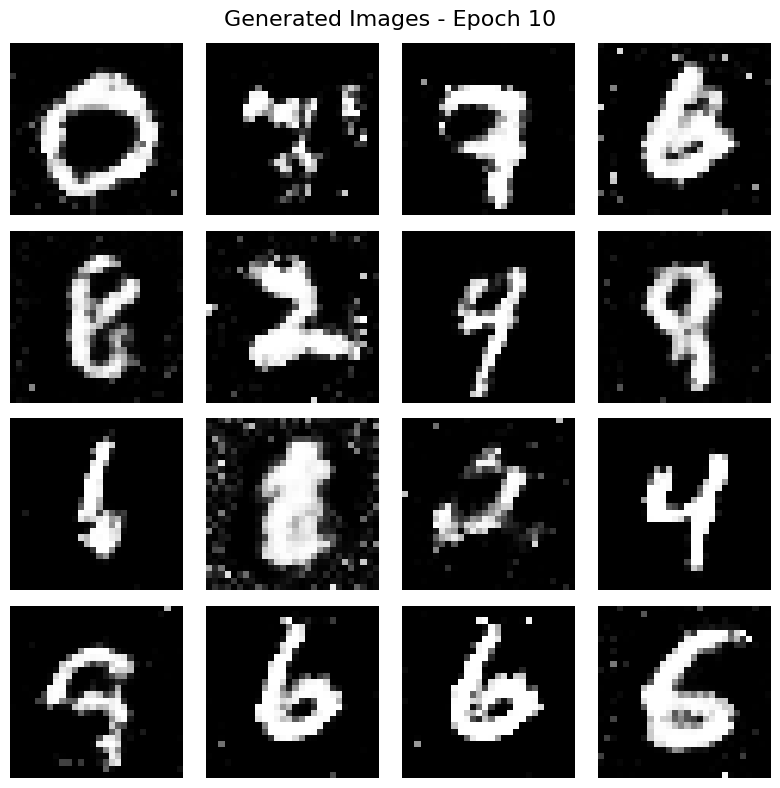

Epoch [11/50], Batch [0/469], Loss D: 1.0856, Loss G: 1.4315, D(x): 0.6599, D(G(z)): 0.3969 / 0.2812
Epoch [11/50], Batch [100/469], Loss D: 1.0778, Loss G: 1.0710, D(x): 0.5856, D(G(z)): 0.3301 / 0.3936
Epoch [11/50], Batch [200/469], Loss D: 1.1014, Loss G: 1.1231, D(x): 0.5649, D(G(z)): 0.3429 / 0.3748
Epoch [11/50], Batch [300/469], Loss D: 1.1836, Loss G: 1.1758, D(x): 0.6238, D(G(z)): 0.4143 / 0.3484
Epoch [11/50], Batch [400/469], Loss D: 1.1105, Loss G: 1.1905, D(x): 0.5845, D(G(z)): 0.3585 / 0.3399
Epoch [12/50], Batch [0/469], Loss D: 1.0857, Loss G: 1.1257, D(x): 0.5967, D(G(z)): 0.3631 / 0.3662
Epoch [12/50], Batch [100/469], Loss D: 1.0731, Loss G: 1.1358, D(x): 0.5557, D(G(z)): 0.3034 / 0.3685
Epoch [12/50], Batch [200/469], Loss D: 1.1348, Loss G: 1.0494, D(x): 0.5227, D(G(z)): 0.3011 / 0.3899
Epoch [12/50], Batch [300/469], Loss D: 1.0611, Loss G: 1.1477, D(x): 0.6148, D(G(z)): 0.3575 / 0.3662
Epoch [12/50], Batch [400/469], Loss D: 1.1861, Loss G: 1.0552, D(x): 0.5533,

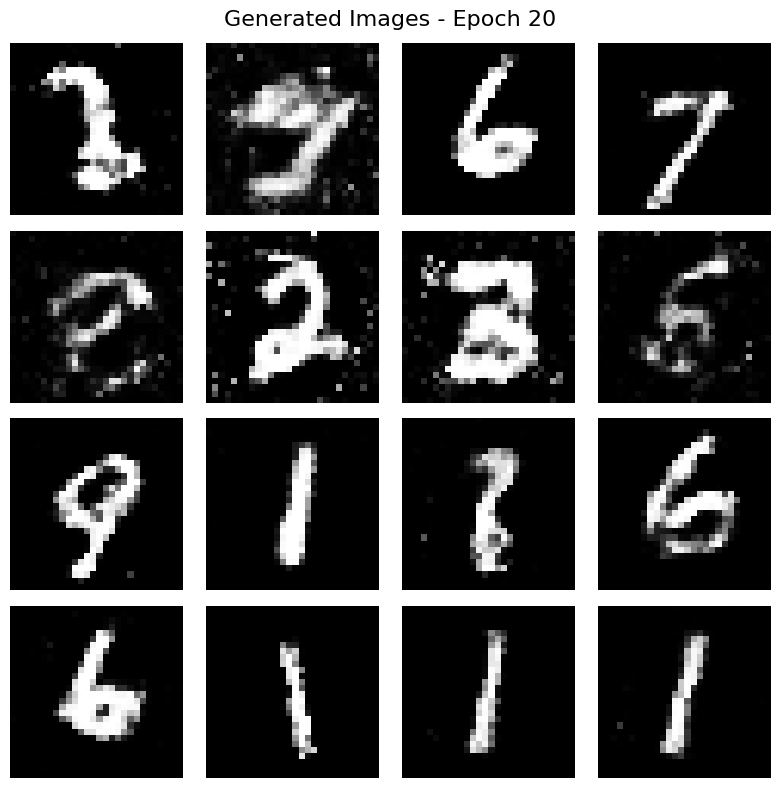

Epoch [21/50], Batch [0/469], Loss D: 1.1943, Loss G: 1.3173, D(x): 0.7020, D(G(z)): 0.4931 / 0.3108
Epoch [21/50], Batch [100/469], Loss D: 1.1854, Loss G: 1.4453, D(x): 0.7164, D(G(z)): 0.5062 / 0.2658
Epoch [21/50], Batch [200/469], Loss D: 1.0480, Loss G: 1.1804, D(x): 0.6372, D(G(z)): 0.3770 / 0.3456
Epoch [21/50], Batch [300/469], Loss D: 1.1288, Loss G: 1.0486, D(x): 0.5864, D(G(z)): 0.3776 / 0.3915
Epoch [21/50], Batch [400/469], Loss D: 1.1709, Loss G: 1.1990, D(x): 0.6276, D(G(z)): 0.4222 / 0.3341
Epoch [22/50], Batch [0/469], Loss D: 1.2053, Loss G: 1.3369, D(x): 0.6218, D(G(z)): 0.4258 / 0.3054
Epoch [22/50], Batch [100/469], Loss D: 1.1502, Loss G: 1.2548, D(x): 0.6060, D(G(z)): 0.3808 / 0.3193
Epoch [22/50], Batch [200/469], Loss D: 1.0090, Loss G: 1.2279, D(x): 0.6249, D(G(z)): 0.3371 / 0.3314
Epoch [22/50], Batch [300/469], Loss D: 1.1473, Loss G: 1.1359, D(x): 0.6376, D(G(z)): 0.4257 / 0.3490
Epoch [22/50], Batch [400/469], Loss D: 1.1616, Loss G: 1.1259, D(x): 0.5707,

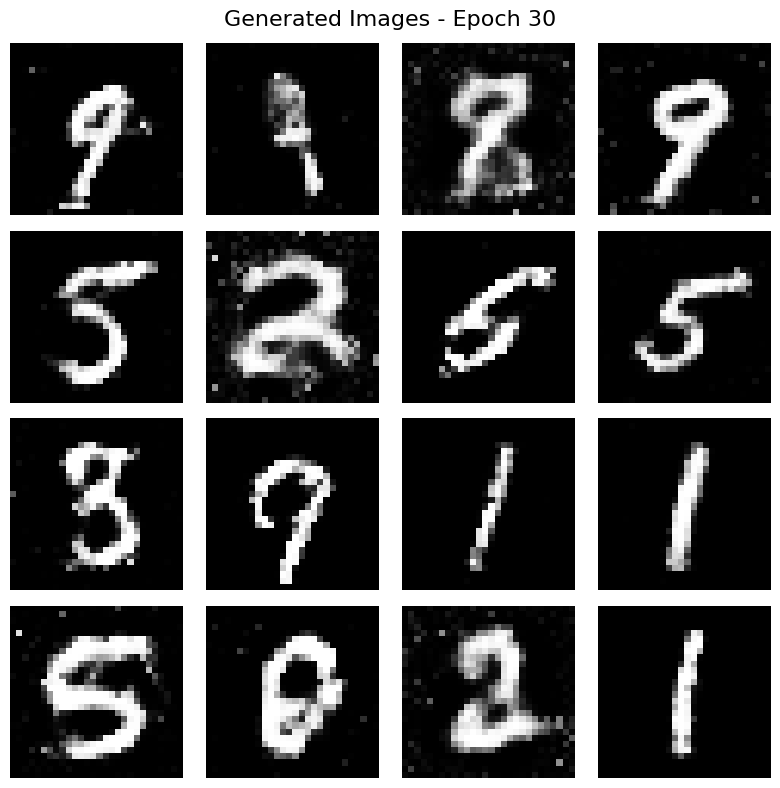

Epoch [31/50], Batch [0/469], Loss D: 1.0932, Loss G: 1.0818, D(x): 0.6105, D(G(z)): 0.3564 / 0.3819
Epoch [31/50], Batch [100/469], Loss D: 1.2318, Loss G: 0.9053, D(x): 0.4945, D(G(z)): 0.3046 / 0.4634
Epoch [31/50], Batch [200/469], Loss D: 1.1055, Loss G: 1.0037, D(x): 0.5646, D(G(z)): 0.3296 / 0.4135
Epoch [31/50], Batch [300/469], Loss D: 1.0424, Loss G: 1.2469, D(x): 0.7009, D(G(z)): 0.4349 / 0.3225
Epoch [31/50], Batch [400/469], Loss D: 1.2398, Loss G: 1.1293, D(x): 0.5294, D(G(z)): 0.3547 / 0.3681
Epoch [32/50], Batch [0/469], Loss D: 1.1112, Loss G: 0.9415, D(x): 0.5722, D(G(z)): 0.3340 / 0.4394
Epoch [32/50], Batch [100/469], Loss D: 1.2076, Loss G: 0.8855, D(x): 0.5817, D(G(z)): 0.4109 / 0.4485
Epoch [32/50], Batch [200/469], Loss D: 1.1261, Loss G: 1.1946, D(x): 0.6396, D(G(z)): 0.4161 / 0.3512
Epoch [32/50], Batch [300/469], Loss D: 1.1103, Loss G: 1.1013, D(x): 0.5581, D(G(z)): 0.3140 / 0.3692
Epoch [32/50], Batch [400/469], Loss D: 1.1969, Loss G: 1.0261, D(x): 0.5248,

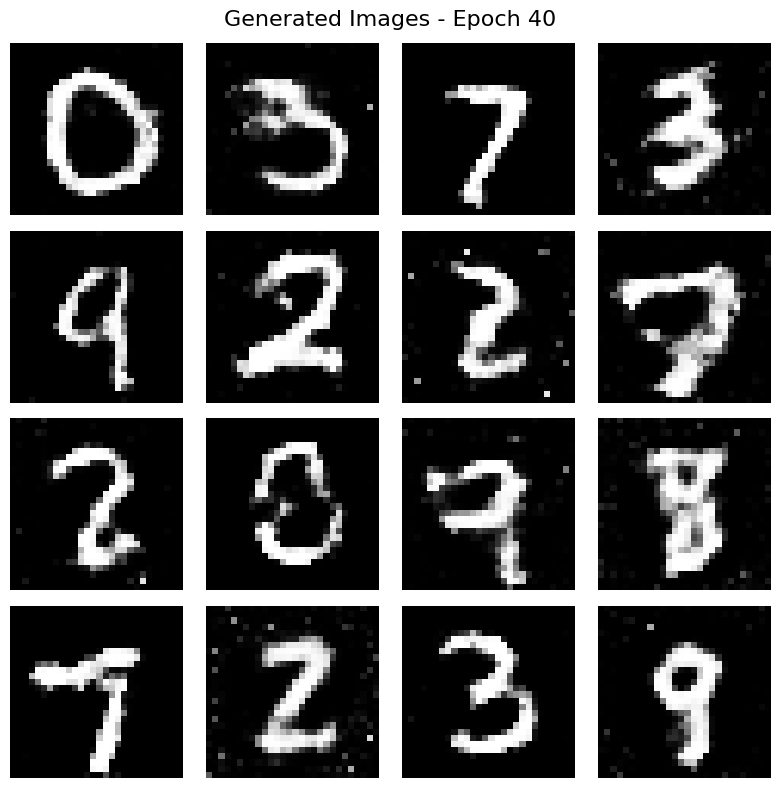

Epoch [41/50], Batch [0/469], Loss D: 1.2721, Loss G: 0.8399, D(x): 0.4791, D(G(z)): 0.3233 / 0.4652
Epoch [41/50], Batch [100/469], Loss D: 1.1367, Loss G: 1.1455, D(x): 0.5767, D(G(z)): 0.3588 / 0.3671
Epoch [41/50], Batch [200/469], Loss D: 1.1202, Loss G: 1.0610, D(x): 0.5815, D(G(z)): 0.3653 / 0.3840
Epoch [41/50], Batch [300/469], Loss D: 1.2463, Loss G: 1.1264, D(x): 0.5464, D(G(z)): 0.3764 / 0.3633
Epoch [41/50], Batch [400/469], Loss D: 1.1316, Loss G: 1.1387, D(x): 0.5636, D(G(z)): 0.3497 / 0.3581
Epoch [42/50], Batch [0/469], Loss D: 1.1308, Loss G: 1.0961, D(x): 0.5940, D(G(z)): 0.3759 / 0.3736
Epoch [42/50], Batch [100/469], Loss D: 1.1874, Loss G: 1.2102, D(x): 0.6605, D(G(z)): 0.4556 / 0.3473
Epoch [42/50], Batch [200/469], Loss D: 1.2264, Loss G: 1.0058, D(x): 0.5945, D(G(z)): 0.4234 / 0.4009
Epoch [42/50], Batch [300/469], Loss D: 1.1699, Loss G: 0.9077, D(x): 0.5242, D(G(z)): 0.3072 / 0.4347
Epoch [42/50], Batch [400/469], Loss D: 1.1465, Loss G: 1.1432, D(x): 0.6068,

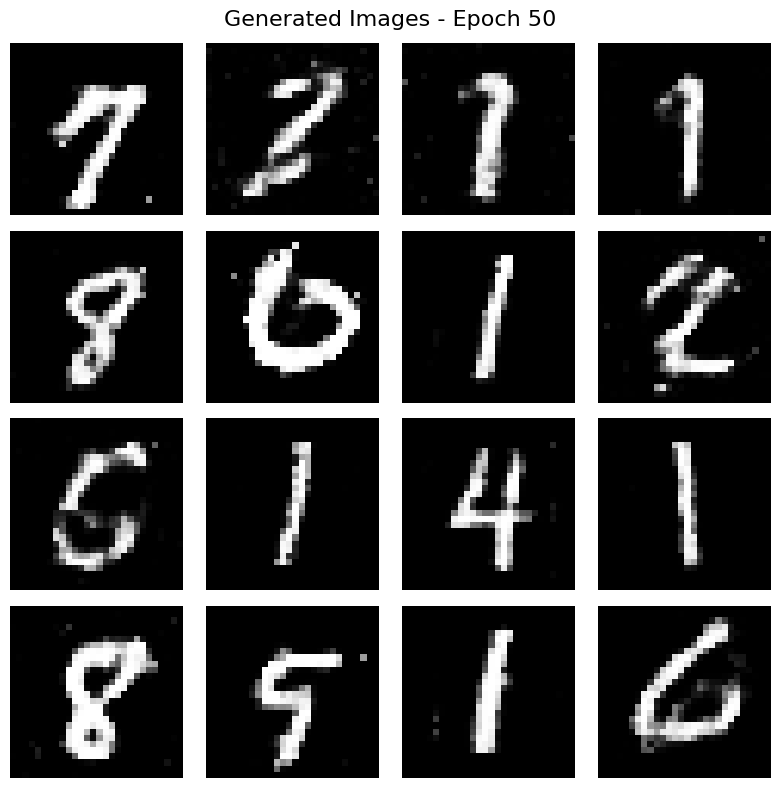

Training completed!


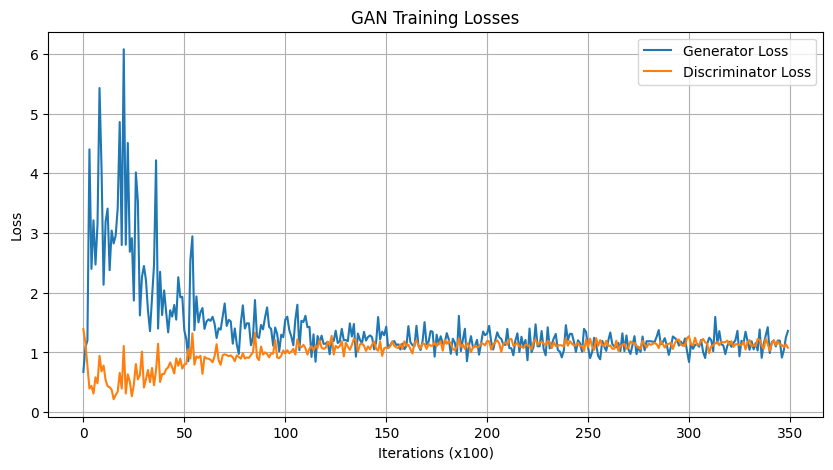

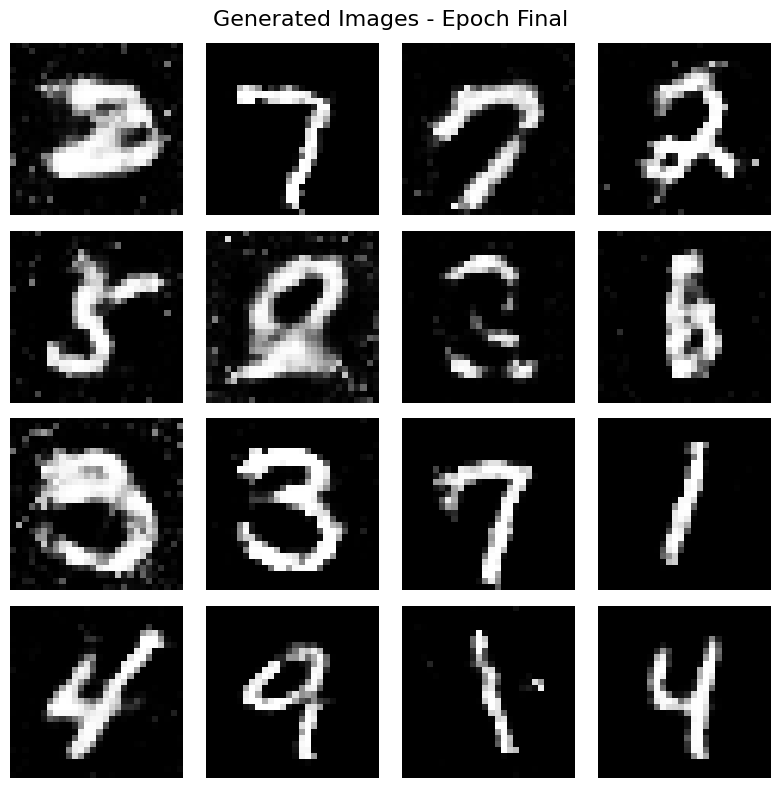

In [11]:
# Training loop
for epoch in range(num_epochs):
    for i, (real_images, _) in enumerate(dataloader):
        # Flatten images and move to device
        real_images = real_images.view(-1, img_dim).to(device)
        batch_size = real_images.size(0)

        # Create labels
        real_labels = torch.full((batch_size, 1), real_label, device=device)
        fake_labels = torch.full((batch_size, 1), fake_label, device=device)

        # ---------------------
        #  Train Discriminator
        # ---------------------
        discriminator.zero_grad()

        # Train with real images
        output = discriminator(real_images)
        errD_real = criterion(output, real_labels)
        errD_real.backward()
        D_x = output.mean().item()

        # Train with fake images
        noise = torch.randn(batch_size, noise_dim, device=device)
        fake_images = generator(noise)
        output = discriminator(fake_images.detach()) # Detach to prevent generator training
        errD_fake = criterion(output, fake_labels)
        errD_fake.backward()
        D_G_z1 = output.mean().item()

        # Combine and update discriminator
        errD = errD_real + errD_fake
        optimizer_D.step()

        # -----------------
        #  Train Generator
        # -----------------
        generator.zero_grad()
        output = discriminator(fake_images) # Train generator to fool discriminator
        errG = criterion(output, real_labels) # Generator wants discriminator to output 1 (real)
        errG.backward()
        D_G_z2 = output.mean().item()

        # Update generator
        optimizer_G.step()

        # Save Losses for plotting later
        if i % 100 == 0:
            G_losses.append(errG.item())
            D_losses.append(errD.item())
            print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{i}/{len(dataloader)}], Loss D: {errD.item():.4f}, Loss G: {errG.item():.4f}, D(x): {D_x:.4f}, D(G(z)): {D_G_z1:.4f} / {D_G_z2:.4f}')

    # Generate and display images every 10 epochs
    if (epoch + 1) % 10 == 0:
        generate_and_display_images(epoch + 1)

print("Training completed!")
plot_losses()
generate_and_display_images("Final")

### 📊 Results Visualization

**Generated Images Display:**
- Shows 4×4 grid of generated digits
- Images denormalized from [-1,1] to [0,1] for proper visualization
- Generated every 10 epochs to track progress

**Loss Plotting:**
- **Generator Loss**: Should generally decrease over time
- **Discriminator Loss**: Should stabilize around 0.5 (random guessing)
- **Convergence**: Both losses oscillating indicates healthy competition

**Training Success Indicators:**
- Generated digits become increasingly realistic
- Loss curves show convergence without mode collapse
- Diversity in generated digit styles and orientations


Training completed!


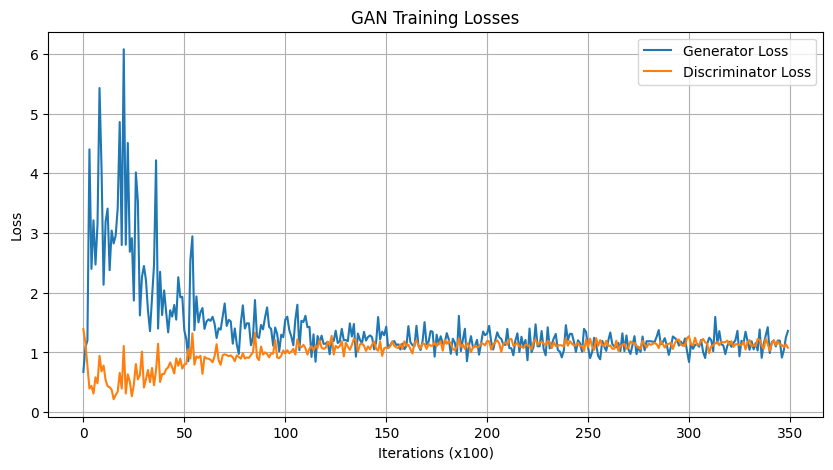

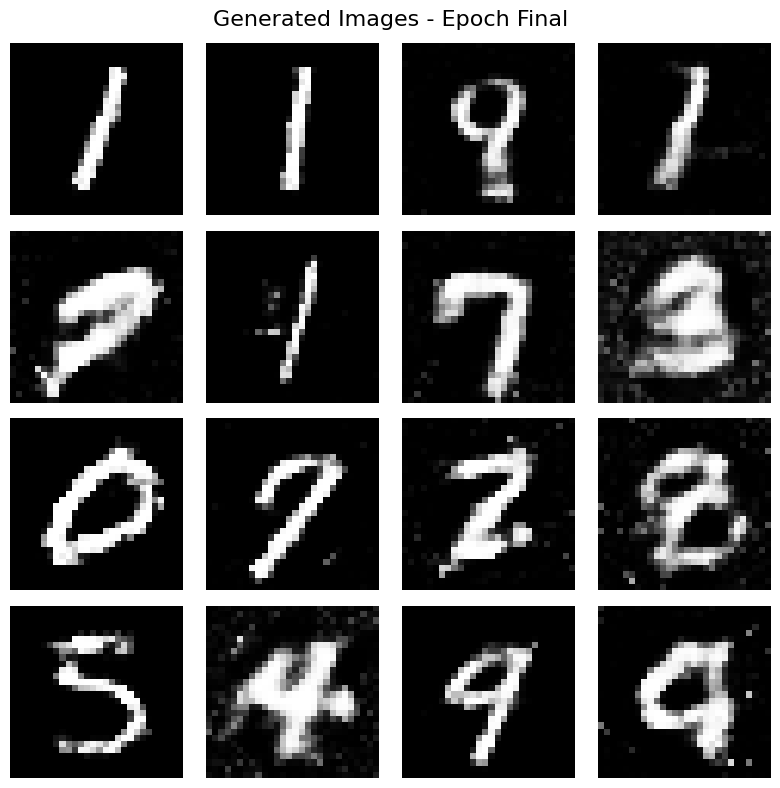

In [13]:
def generate_and_display_images(epoch):
    generator.eval()
    with torch.no_grad():
        # Generate 16 sample images
        noise = torch.randn(16, noise_dim, device=device)
        fake_images = generator(noise)
        fake_images = fake_images.view(-1, 1, 28, 28)
        fake_images = (fake_images + 1) / 2  # Denormalize to [0, 1]

        # Create subplot
        fig, axes = plt.subplots(4, 4, figsize=(8, 8))
        fig.suptitle(f'Generated Images - Epoch {epoch}', fontsize=16)

        for i, ax in enumerate(axes.flat):
            ax.imshow(fake_images[i].cpu().squeeze(), cmap='gray')
            ax.axis('off')

        plt.tight_layout()
        plt.show()

    generator.train()

# Plot training losses
def plot_losses():
    plt.figure(figsize=(10, 5))
    plt.plot(G_losses, label='Generator Loss')
    plt.plot(D_losses, label='Discriminator Loss')
    plt.xlabel('Iterations (x100)')
    plt.ylabel('Loss')
    plt.title('GAN Training Losses')
    plt.legend()
    plt.grid(True)
    plt.show()

# Display final results
print("Training completed!")
plot_losses()
generate_and_display_images("Final")


### 🎯 Final Model Usage

**Generating New Samples:**
- Create random noise vectors
- Pass through trained generator
- Convert to viewable images
- Display in organized grid

**Model Persistence:**
- Save generator and discriminator weights
- Models can be loaded later for continued training or inference
- Enables deployment and sharing of trained GANs

**Project Achievement:**
You've successfully implemented a GAN that can generate realistic handwritten digits! The model learned to capture the essential characteristics of the MNIST dataset through adversarial training.


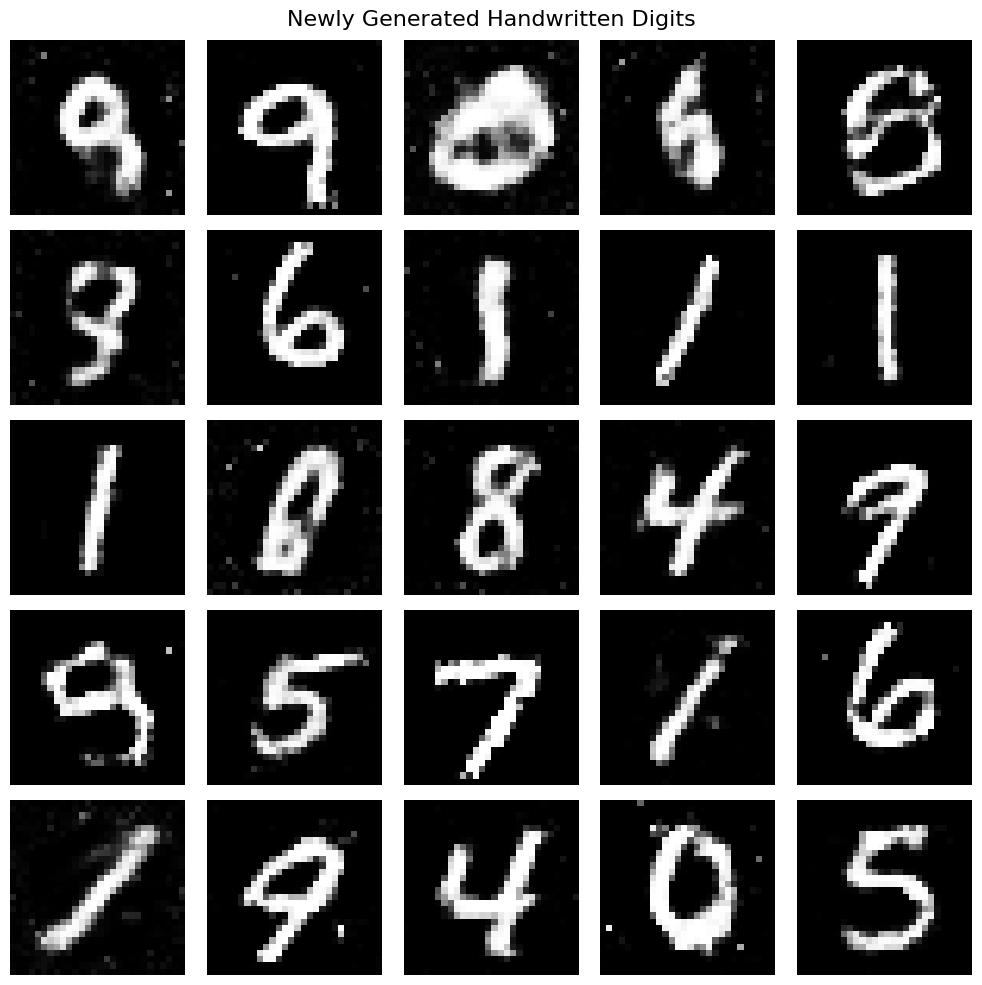

Models saved successfully!


In [14]:
def generate_specific_samples(num_samples=25):
    """Generate a batch of new digit samples"""
    generator.eval()
    with torch.no_grad():
        noise = torch.randn(num_samples, noise_dim, device=device)
        fake_images = generator(noise)
        fake_images = fake_images.view(-1, 1, 28, 28)
        fake_images = (fake_images + 1) / 2  # Denormalize

        # Display in 5x5 grid
        fig, axes = plt.subplots(5, 5, figsize=(10, 10))
        fig.suptitle('Newly Generated Handwritten Digits', fontsize=16)

        for i, ax in enumerate(axes.flat):
            ax.imshow(fake_images[i].cpu().squeeze(), cmap='gray')
            ax.axis('off')

        plt.tight_layout()
        plt.show()

    generator.train()

# Generate fresh samples
generate_specific_samples()

# Save the trained models
torch.save(generator.state_dict(), 'generator_mnist.pth')
torch.save(discriminator.state_dict(), 'discriminator_mnist.pth')
print("Models saved successfully!")
